# Continuous Control

---

In this notebook, you will learn how to use the Unity ML-Agents environment for the second project of the [Deep Reinforcement Learning Nanodegree](https://www.udacity.com/course/deep-reinforcement-learning-nanodegree--nd893) program.

### 1. Start the Environment

We begin by importing the necessary packages.  If the code cell below returns an error, please revisit the project instructions to double-check that you have installed [Unity ML-Agents](https://github.com/Unity-Technologies/ml-agents/blob/master/docs/Installation.md) and [NumPy](http://www.numpy.org/).

In [1]:
import matplotlib.pyplot as plt
import json

import numpy as np
import random
import copy
from collections import namedtuple, deque

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

Next, we will start the environment!  **_Before running the code cell below_**, change the `file_name` parameter to match the location of the Unity environment that you downloaded.

- **Mac**: `"path/to/Reacher.app"`
- **Windows** (x86): `"path/to/Reacher_Windows_x86/Reacher.exe"`
- **Windows** (x86_64): `"path/to/Reacher_Windows_x86_64/Reacher.exe"`
- **Linux** (x86): `"path/to/Reacher_Linux/Reacher.x86"`
- **Linux** (x86_64): `"path/to/Reacher_Linux/Reacher.x86_64"`
- **Linux** (x86, headless): `"path/to/Reacher_Linux_NoVis/Reacher.x86"`
- **Linux** (x86_64, headless): `"path/to/Reacher_Linux_NoVis/Reacher.x86_64"`

For instance, if you are using a Mac, then you downloaded `Reacher.app`.  If this file is in the same folder as the notebook, then the line below should appear as follows:
```
env = UnityEnvironment(file_name="Reacher.app")
```

In [2]:
# For local machine
!pip -q install ./python
from unityagents import UnityEnvironment
# env = UnityEnvironment(file_name='./Reacher_Linux/Reacher.x86_64')
# env = UnityEnvironment(file_name='./Reacher_Windows_x86_64/Reacher.exe')
env = UnityEnvironment(file_name='/data/Reacher_One_Linux_NoVis/Reacher_One_Linux_NoVis.x86_64')

# # For Udacity Workspace
# !pip -q install ./python
# from unityagents import UnityEnvironment

# # # select this option to load version 1 (with a single agent) of the environment
# # env = UnityEnvironment(file_name='/data/Reacher_One_Linux_NoVis/Reacher_One_Linux_NoVis.x86_64')

# # select this option to load version 2 (with 20 agents) of the environment
# env = UnityEnvironment(file_name='/data/Reacher_Linux_NoVis/Reacher.x86_64')

tensorflow 1.7.1 has requirement numpy>=1.13.3, but you'll have numpy 1.12.1 which is incompatible.
ipython 6.5.0 has requirement prompt-toolkit<2.0.0,>=1.0.15, but you'll have prompt-toolkit 3.0.5 which is incompatible.


INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		goal_speed -> 1.0
		goal_size -> 5.0
Unity brain name: ReacherBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 33
        Number of stacked Vector Observation: 1
        Vector Action space type: continuous
        Vector Action space size (per agent): 4
        Vector Action descriptions: , , , 


Environments contain **_brains_** which are responsible for deciding the actions of their associated agents. Here we check for the first brain available, and set it as the default brain we will be controlling from Python.

In [3]:
# get the default brain
brain_name = env.brain_names[0]
brain = env.brains[brain_name]

### 2. Examine the State and Action Spaces

In this environment, a double-jointed arm can move to target locations. A reward of `+0.1` is provided for each step that the agent's hand is in the goal location. Thus, the goal of your agent is to maintain its position at the target location for as many time steps as possible.

The observation space consists of `33` variables corresponding to position, rotation, velocity, and angular velocities of the arm.  Each action is a vector with four numbers, corresponding to torque applicable to two joints.  Every entry in the action vector must be a number between `-1` and `1`.

Run the code cell below to print some information about the environment.

In [4]:
# reset the environment
env_info = env.reset(train_mode=True)[brain_name]

# number of agents
num_agents = len(env_info.agents)
print('Number of agents:', num_agents, env_info.vector_observations.shape[0])

# size of each action
action_size = brain.vector_action_space_size
print('Size of each action:', action_size)

# examine the state space 
states = env_info.vector_observations
state_size = states.shape[1]
print('There are {} agents. Each observes a state with length: {}'.format(states.shape[0], state_size))
print('The state for the first agent looks like:', states[0])

print(states[0].shape, states[0,:].shape)

Number of agents: 1 1
Size of each action: 4
There are 1 agents. Each observes a state with length: 33
The state for the first agent looks like: [  0.00000000e+00  -4.00000000e+00   0.00000000e+00   1.00000000e+00
  -0.00000000e+00  -0.00000000e+00  -4.37113883e-08   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00  -1.00000000e+01   0.00000000e+00
   1.00000000e+00  -0.00000000e+00  -0.00000000e+00  -4.37113883e-08
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   5.75471878e+00  -1.00000000e+00
   5.55726671e+00   0.00000000e+00   1.00000000e+00   0.00000000e+00
  -1.68164849e-01]
(33,) (33,)


### 3. Agent Training (Using DDPG)

Train the agent to solve the environment!  When training the environment, set `train_mode=True`, so that the line for resetting the environment looks like the following:
```python
env_info = env.reset(train_mode=True)[brain_name]
```

In [5]:
#Actor and Critic Networks
def hidden_init(layer):
    fan_in = layer.weight.data.size()[0]
    lim = 1. / np.sqrt(fan_in)
    return (-lim, lim)


class Actor(nn.Module):
    """Actor (Policy) Model."""

    def __init__(self, state_size, action_size, seed, fc1_units=256, fc2_units=128):
        """Initialize parameters and build model.
        Params
        ======
            state_size (int): Dimension of each state
            action_size (int): Dimension of each action
            seed (int): Random seed
            fc1_units (int): Number of nodes in first hidden layer
            fc2_units (int): Number of nodes in second hidden layer
        """
        super(Actor, self).__init__()
        self.seed = torch.manual_seed(seed)
        self.fc1 = nn.Linear(state_size, fc1_units)
        self.fc2 = nn.Linear(fc1_units, fc2_units)
        self.fc3 = nn.Linear(fc2_units, action_size)
        self.reset_parameters()

    def reset_parameters(self):
        self.fc1.weight.data.uniform_(*hidden_init(self.fc1))
        self.fc2.weight.data.uniform_(*hidden_init(self.fc2))
        self.fc3.weight.data.uniform_(-3e-3, 3e-3)

    def forward(self, state):
        """Build an actor (policy) network that maps states -> actions."""
        x = F.elu(self.fc1(state))
        x = F.elu(self.fc2(x))
        return F.tanh(self.fc3(x))


class Critic(nn.Module):
    """Critic (Value) Model."""

    def __init__(self, state_size, action_size, seed, fcs1_units=256, fc2_units=128):
        """Initialize parameters and build model.
        Params
        ======
            state_size (int): Dimension of each state
            action_size (int): Dimension of each action
            seed (int): Random seed
            fcs1_units (int): Number of nodes in the first hidden layer
            fc2_units (int): Number of nodes in the second hidden layer
        """
        super(Critic, self).__init__()
        self.seed = torch.manual_seed(seed)
        self.fcs1 = nn.Linear(state_size, fcs1_units)
        self.fc2 = nn.Linear(fcs1_units+action_size, fc2_units)
        self.fc3 = nn.Linear(fc2_units, 1)
        self.reset_parameters()

    def reset_parameters(self):
        self.fcs1.weight.data.uniform_(*hidden_init(self.fcs1))
        self.fc2.weight.data.uniform_(*hidden_init(self.fc2))
        self.fc3.weight.data.uniform_(-3e-3, 3e-3)

    def forward(self, state, action):
        """Build a critic (value) network that maps (state, action) pairs -> Q-values."""
        xs = F.elu(self.fcs1(state))
        x = torch.cat((xs, action), dim=1)
        x = F.elu(self.fc2(x))
        return self.fc3(x)


In [6]:
#Agent
BUFFER_SIZE = int(1e5)  # replay buffer size
BATCH_SIZE = 128        # minibatch size
GAMMA = 0.99            # discount factor
TAU = 1e-3              # for soft update of target parameters
LR_ACTOR = 1e-4 #3e-5 #1e-4         # learning rate of the actor 
LR_CRITIC = 1e-4 #3e-5 #1e-4        # learning rate of the critic
WEIGHT_DECAY_actor = 0.0 #3e-4 #0        # L2 weight decay
WEIGHT_DECAY_critic = 0.0 #1e-6 #0        # L2 weight decay

#to decay exploration as it learns
EPS_START=1
EPS_END=0.05
EPS_DECAY=3e-5

class Agent():
    """Interacts with and learns from the environment."""
    
    def __init__(self, state_size, action_size, num_agents, random_seed):
        """Initialize an Agent object.
        
        Params
        ======
            state_size (int): dimension of each state
            action_size (int): dimension of each action
            random_seed (int): random seed
        """
        self.state_size = state_size
        self.action_size = action_size
        self.num_agents = num_agents
        self.seed = random.seed(random_seed)

        # Actor Network (w/ Target Network)
        self.actor_local = Actor(state_size, action_size, random_seed).to(device)
        self.actor_target = Actor(state_size, action_size, random_seed).to(device)
        self.actor_optimizer = optim.Adam(self.actor_local.parameters(), lr=LR_ACTOR, weight_decay=WEIGHT_DECAY_actor)

        # Critic Network (w/ Target Network)
        self.critic_local = Critic(state_size, action_size, random_seed).to(device)
        self.critic_target = Critic(state_size, action_size, random_seed).to(device)
        self.critic_optimizer = optim.Adam(self.critic_local.parameters(), lr=LR_CRITIC, weight_decay=WEIGHT_DECAY_critic)

        # Noise process
        #self.noise = OUNoise(action_size, random_seed) #single agent only
        self.noise = OUNoise((num_agents, action_size), random_seed) #both singe and multiple agent
        self.eps = EPS_START

        # Replay memory
        self.memory = ReplayBuffer(action_size, BUFFER_SIZE, BATCH_SIZE, random_seed)
    
        # Make sure target is initialized with the same weight as the source (found on slack to make big difference)
        self.hard_update(self.actor_target, self.actor_local)
        self.hard_update(self.critic_target, self.critic_local)


    def step(self, states, actions, rewards, next_states, dones):
        """Save experience in replay memory, and use random sample from buffer to learn."""
        # Save experience / reward
        #Experience from each agent is separately saved (so it works for single or multi agent environment)
        #This works because each agent is operating in a separate/independent environment
        for a in range(self.num_agents):
            self.memory.add(states[a], actions[a], rewards[a], next_states[a], dones[a])

        # Learn, if enough samples are available in memory
        if len(self.memory) > BATCH_SIZE:
            experiences = self.memory.sample()
            self.learn(experiences, GAMMA)

    def act(self, states, add_noise=True):
        """Returns actions for given state as per current policy."""
        states = torch.from_numpy(states).float().to(device)
        self.actor_local.eval()
        with torch.no_grad():
            actions = self.actor_local(states).cpu().data.numpy()
        self.actor_local.train()
        
        #add noise according to epsilon probability
        if add_noise and (np.random.random() < self.eps):
            actions += self.noise.sample()
            #update the exploration parameter
            self.eps -= EPS_DECAY
            if self.eps < EPS_END:
                self.eps = EPS_END
            #self.noise.reset() #not sure if need to do this here

        return np.clip(actions, -1, 1)

    def reset(self):
        self.noise.reset()

    def learn(self, experiences, gamma):
        """Update policy and value parameters using given batch of experience tuples.
        Q_targets = r + γ * critic_target(next_state, actor_target(next_state))
        where:
            actor_target(state) -> action
            critic_target(state, action) -> Q-value

        Params
        ======
            experiences (Tuple[torch.Tensor]): tuple of (s, a, r, s', done) tuples 
            gamma (float): discount factor
        """
        states, actions, rewards, next_states, dones = experiences

        # ---------------------------- update critic ---------------------------- #
        # Get predicted next-state actions and Q values from target models
        actions_next = self.actor_target(next_states)
        Q_targets_next = self.critic_target(next_states, actions_next)
        # Compute Q targets for current states (y_i)
        Q_targets = rewards + (gamma * Q_targets_next * (1 - dones))
        # Compute critic loss
        Q_expected = self.critic_local(states, actions)
        critic_loss = F.mse_loss(Q_expected, Q_targets)
        # Minimize the loss
        self.critic_optimizer.zero_grad()
        critic_loss.backward()
        torch.nn.utils.clip_grad_norm(self.critic_local.parameters(), 1.0) #clip the gradient for the critic network (Udacity hint)
        self.critic_optimizer.step()

        # ---------------------------- update actor ---------------------------- #
        # Compute actor loss
        actions_pred = self.actor_local(states)
        actor_loss = -self.critic_local(states, actions_pred).mean()
        # Minimize the loss
        self.actor_optimizer.zero_grad()
        actor_loss.backward()
        self.actor_optimizer.step()

        # ----------------------- update target networks ----------------------- #
        self.soft_update(self.critic_local, self.critic_target, TAU)
        self.soft_update(self.actor_local, self.actor_target, TAU)                     

    def soft_update(self, local_model, target_model, tau):
        """Soft update model parameters.
        θ_target = τ*θ_local + (1 - τ)*θ_target

        Params
        ======
            local_model: PyTorch model (weights will be copied from)
            target_model: PyTorch model (weights will be copied to)
            tau (float): interpolation parameter 
        """
        for target_param, local_param in zip(target_model.parameters(), local_model.parameters()):
            target_param.data.copy_(tau*local_param.data + (1.0-tau)*target_param.data)


    ## from slack - Since you're using DDPG, @gregoriomezquita mentioned that 
    ## initializing the weights of the target networks to be the same as those 
    ## of the live networks seemed to make a huge difference
    def hard_update(self, target, source):
        for target_param, source_param in zip(target.parameters(), source.parameters()):
            target_param.data.copy_(source_param.data)


class OUNoise:
    """Ornstein-Uhlenbeck process."""

    def __init__(self, size, seed, mu=0., theta=0.15, sigma=0.2):
        """Initialize parameters and noise process."""
        self.mu = mu * np.ones(size)
        self.theta = theta
        self.sigma = sigma
        self.seed = random.seed(seed)
        self.size = size
        self.reset()

    def reset(self):
        """Reset the internal state (= noise) to mean (mu)."""
        self.state = copy.copy(self.mu)

    def sample(self):
        """Update internal state and return it as a noise sample."""
        x = self.state
        #dx = self.theta * (self.mu - x) + self.sigma * np.array([random.random() for i in range(len(x))])
        dx = self.theta * (self.mu - x) + self.sigma * np.random.standard_normal(self.size)
        self.state = x + dx
        return self.state

class ReplayBuffer:
    """Fixed-size buffer to store experience tuples."""

    def __init__(self, action_size, buffer_size, batch_size, seed):
        """Initialize a ReplayBuffer object.
        Params
        ======
            buffer_size (int): maximum size of buffer
            batch_size (int): size of each training batch
        """
        self.action_size = action_size
        self.memory = deque(maxlen=buffer_size)  # internal memory (deque)
        self.batch_size = batch_size
        self.experience = namedtuple("Experience", field_names=["state", "action", "reward", "next_state", "done"])
        self.seed = random.seed(seed)
    
    def add(self, state, action, reward, next_state, done):
        """Add a new experience to memory."""
        e = self.experience(state, action, reward, next_state, done)
        self.memory.append(e)
    
    def sample(self):
        """Randomly sample a batch of experiences from memory."""
        experiences = random.sample(self.memory, k=self.batch_size)

        states = torch.from_numpy(np.vstack([e.state for e in experiences if e is not None])).float().to(device)
        actions = torch.from_numpy(np.vstack([e.action for e in experiences if e is not None])).float().to(device)
        rewards = torch.from_numpy(np.vstack([e.reward for e in experiences if e is not None])).float().to(device)
        next_states = torch.from_numpy(np.vstack([e.next_state for e in experiences if e is not None])).float().to(device)
        dones = torch.from_numpy(np.vstack([e.done for e in experiences if e is not None]).astype(np.uint8)).float().to(device)

        return (states, actions, rewards, next_states, dones)

    def __len__(self):
        """Return the current size of internal memory."""
        return len(self.memory)

In [7]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

agent = Agent(state_size=env_info.vector_observations.shape[1], action_size=brain.vector_action_space_size, 
              num_agents=env_info.vector_observations.shape[0],  random_seed=0)

# agent.actor_local.load_state_dict(torch.load('checkpoint_actor.pth'))
# agent.critic_local.load_state_dict(torch.load('checkpoint_critic.pth'))

#for single and multiple agents
def ddpg(n_episodes=2000):
    scores_deque = deque(maxlen=100)
    scores_list = []
    for i_episode in range(1, n_episodes+1):
        env_info = env.reset(train_mode=True)[brain_name]     # reset the environment
        states = env_info.vector_observations                   # get the current states (for all agents)
        agent.reset() #reset the agent OU Noise
        scores = np.zeros(num_agents)                          # initialize the score (for each agent)
        while True:
            actions = agent.act(states)
            env_info = env.step(actions)[brain_name]           # send all actions to the environment
            next_states = env_info.vector_observations         # get next state (for each agent)
            rewards = env_info.rewards                         # get rewards (for each agent)
            dones = env_info.local_done                        # see if episode finished
            scores += rewards                                  # update the score (for each agent)
            agent.step(states, actions, rewards, next_states, dones) #train the agent
            
            # Extra Learning per time step (since generating so much experience at each step)
            if len(agent.memory) > BATCH_SIZE:
                for _ in range(3):
                    experiences = agent.memory.sample()
                    agent.learn(experiences, GAMMA)
            
            states = next_states                               # roll over states to next time step
            if np.any(dones):                                  # exit loop if episode finished
                break
            #print('Total score (averaged over agents) this episode: {}'.format(np.mean(score)))
        
        scores_deque.append(np.mean(scores))
        scores_list.append(np.mean(scores))
        
        #print('\rEpisode {}\tAverage Score: {:.2f}\tScore: {}'.format(i_episode, np.mean(scores_deque), score), end="")
        print('Episode {}\tAverage Score: {:.2f}\tScore: {}'.format(i_episode, np.mean(scores_deque), np.mean(scores)))
        print('Epsilon: {} and Memory size: {}'.format(agent.eps, len(agent.memory)))
        
        if i_episode % 100 == 0:
            torch.save(agent.actor_local.state_dict(), 'checkpoint_actor.pth')
            torch.save(agent.critic_local.state_dict(), 'checkpoint_critic.pth')
            print('\rEpisode {}\tAverage Score: {:.2f}'.format(i_episode, np.mean(scores_deque)))
            
        if np.mean(scores_deque) > 30 and len(scores_deque) >= 100:
            torch.save(agent.actor_local.state_dict(), 'checkpoint_actor.pth')
            torch.save(agent.critic_local.state_dict(), 'checkpoint_critic.pth')
            print('\rEpisode {}\tAverage Score: {:.2f}'.format(i_episode, np.mean(scores_deque)))
            break
            
    return scores_list

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:117: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.


Episode 1	Average Score: 0.88	Score: 0.8799999803304672
Epsilon: 0.9704500000000251 and Memory size: 1001
Episode 2	Average Score: 1.49	Score: 2.109999952837825
Epsilon: 0.9415900000000497 and Memory size: 2002
Episode 3	Average Score: 1.20	Score: 0.5999999865889549
Epsilon: 0.9136300000000734 and Memory size: 3003
Episode 4	Average Score: 1.04	Score: 0.5899999868124723
Epsilon: 0.8865700000000964 and Memory size: 4004
Episode 5	Average Score: 1.12	Score: 1.4399999678134918
Epsilon: 0.860050000000119 and Memory size: 5005
Episode 6	Average Score: 0.99	Score: 0.29999999329447746
Epsilon: 0.8346100000001406 and Memory size: 6006
Episode 7	Average Score: 1.07	Score: 1.5999999642372131
Epsilon: 0.8092900000001622 and Memory size: 7007
Episode 8	Average Score: 1.12	Score: 1.459999967366457
Epsilon: 0.7850800000001827 and Memory size: 8008
Episode 9	Average Score: 1.24	Score: 2.1399999521672726
Epsilon: 0.7615300000002028 and Memory size: 9009
Episode 10	Average Score: 1.25	Score: 1.34999996

Episode 78	Average Score: 2.29	Score: 3.1499999295920134
Epsilon: 0.09949000000062644 and Memory size: 78078
Episode 79	Average Score: 2.31	Score: 3.759999915957451
Epsilon: 0.09676000000062623 and Memory size: 79079
Episode 80	Average Score: 2.37	Score: 6.73999984934926
Epsilon: 0.09346000000062599 and Memory size: 80080
Episode 81	Average Score: 2.38	Score: 3.8199999146163464
Epsilon: 0.09016000000062574 and Memory size: 81081
Episode 82	Average Score: 2.41	Score: 4.819999892264605
Epsilon: 0.08749000000062554 and Memory size: 82082
Episode 83	Average Score: 2.45	Score: 5.1099998857825994
Epsilon: 0.08491000000062535 and Memory size: 83083
Episode 84	Average Score: 2.48	Score: 5.159999884665012
Epsilon: 0.08254000000062517 and Memory size: 84084
Episode 85	Average Score: 2.50	Score: 3.9099999126046896
Epsilon: 0.080350000000625 and Memory size: 85085
Episode 86	Average Score: 2.55	Score: 7.539999831467867
Epsilon: 0.07807000000062483 and Memory size: 86086
Episode 87	Average Score: 2

Episode 161	Average Score: 9.29	Score: 21.789999512955546
Epsilon: 0.05 and Memory size: 100000
Episode 162	Average Score: 9.64	Score: 37.819999154657125
Epsilon: 0.05 and Memory size: 100000
Episode 163	Average Score: 9.75	Score: 15.429999655112624
Epsilon: 0.05 and Memory size: 100000
Episode 164	Average Score: 10.11	Score: 38.399999141693115
Epsilon: 0.05 and Memory size: 100000
Episode 165	Average Score: 10.46	Score: 37.2599991671741
Epsilon: 0.05 and Memory size: 100000
Episode 166	Average Score: 10.81	Score: 38.509999139234424
Epsilon: 0.05 and Memory size: 100000
Episode 167	Average Score: 11.19	Score: 39.33999912068248
Epsilon: 0.05 and Memory size: 100000
Episode 168	Average Score: 11.39	Score: 22.3899994995445
Epsilon: 0.05 and Memory size: 100000
Episode 169	Average Score: 11.70	Score: 34.62999922595918
Epsilon: 0.05 and Memory size: 100000
Episode 170	Average Score: 12.01	Score: 35.46999920718372
Epsilon: 0.05 and Memory size: 100000
Episode 171	Average Score: 12.34	Score: 

Episode 246	Average Score: 29.59	Score: 34.719999223947525
Epsilon: 0.05 and Memory size: 100000
Episode 247	Average Score: 29.78	Score: 31.98999928496778
Epsilon: 0.05 and Memory size: 100000
Episode 248	Average Score: 29.98	Score: 36.08999919332564
Epsilon: 0.05 and Memory size: 100000
Episode 249	Average Score: 30.17	Score: 39.50999911688268
Epsilon: 0.05 and Memory size: 100000
Episode 249	Average Score: 30.17


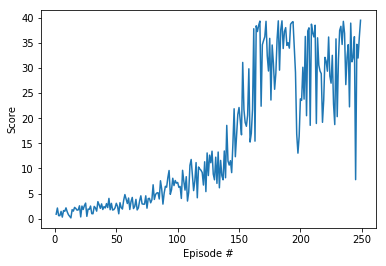

In [9]:
#Use actiove_session() on Udacity workspace
from workspace_utils import active_session

with active_session():
#     # do long-running work here
    scores = ddpg()
    with open("scores_file.json", "w") as write_file:
        json.dump(scores, write_file)

    fig = plt.figure()
    ax = fig.add_subplot(111)
    plt.plot(np.arange(1, len(scores)+1), scores)
    plt.ylabel('Score')
    plt.xlabel('Episode #')
    plt.show()

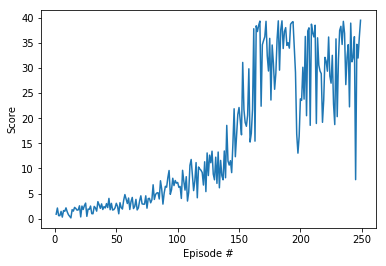

In [10]:
#plot scores
with open("scores_file.json", "r") as read_file:
    scores = json.load(read_file)

fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(np.arange(1, len(scores)+1), scores)
plt.ylabel('Score')
plt.xlabel('Episode #')
plt.show()

In [11]:
#Inference
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

agent = Agent(state_size=env_info.vector_observations.shape[1], action_size=brain.vector_action_space_size, 
              num_agents=env_info.vector_observations.shape[0],  random_seed=0)
#Since the model is trained on gpu, need to load all gpu tensors to cpu:
agent.actor_local.load_state_dict(torch.load('checkpoint_actor.pth', map_location=lambda storage, loc: storage))

agent.eps = 0.05
scores_list = []
def ddpg_inference(n_episodes=3):
    for i_episode in range(1, n_episodes+1):
        env_info = env.reset(train_mode=True)[brain_name]     # reset the environment
        states = env_info.vector_observations                   # get the current states (for all agents)
        agent.reset() #reset the agent OU Noise
        scores = np.zeros(num_agents)                          # initialize the score (for each agent)
        while True:
            actions = agent.act(states)
            env_info = env.step(actions)[brain_name]           # send all actions to the environment
            next_states = env_info.vector_observations         # get next state (for each agent)
            rewards = env_info.rewards                         # get rewards (for each agent)
            dones = env_info.local_done                        # see if episode finished
            scores += rewards                                  # update the score (for each agent)
            states = next_states                               # roll over states to next time step
            if np.any(dones):                                  # exit loop if episode finished
                break
        print('Episode {}: {}'.format(i_episode, np.mean(scores)))
        scores_list.append(np.mean(scores))
    print('Mean score is: ', np.mean(np.array(scores_list)))

ddpg_inference()

Episode 1: 33.76999924518168
Episode 2: 35.03999921679497
Episode 3: 32.87999926507473
Mean score is:  33.896665909


In [12]:
env.close()